Consider the Poisson problem
$$ -\frac{\partial^2 u}{\partial x^2} = f $$

for $x \in [-1,1]$ but with boundary conditions $u(-1) = a$ and $u(1) = b$. Use a mesh spacing of $h = 2/(m+1)$ and grid points at $x_j = -1 + hj$. Define 
$$ f(x) = \begin{cases}
1 \qquad &\text{if } |x| < 1/2 \\
0 \qquad &\text{otherwise}
\end{cases} $$

Write $U = (u_0, \ldots, u_{m+1}) \in \mathbb{R}^{m+2}$ to be a solution vector. By incorporating the Dirichlet conditions, the linear system becomes $AU = F$, which is
$$ \begin{pmatrix} 
\alpha \\
-1 & 2 & -1 \\
& -1 & 2 & -1 \\
&& -1 & \ddots & -1 \\
&&& -1 & 2 & -1 \\
&&&& -1 & 2 & -1 \\
&&&&&& \alpha 
\end{pmatrix} \begin{pmatrix} 
u_0 \\ u_1 \\ u_2 \\ \vdots \\ \vdots \\ u_m \\ u_{m+1}
\end{pmatrix} = \begin{pmatrix} 
\alpha a \\h^2 f_1 \\ h^2 f_2 \\ \vdots \\ \vdots \\ h^2 f_m \\ \alpha b
\end{pmatrix} $$
where $\alpha$ is a nonzero constant.

# Problem 1

Implement the Gauss–Seidel algorithm to solve the system using $m = 31, 63, 127$. Use $\alpha = 1, a = −1, b = 1$ and start from $U$ being identically zero. Terminate your program when the residual $\|AU − F\|_2$ falls below $10^{−8}$. Does the number of
iterations scale like $O(m^2)$ as expected?


m=31	 k=1489
m=63	 k=5486
m=127	 k=20137

a=2.62	 b=1.85


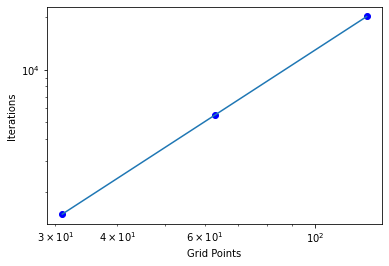

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return 1 if np.abs(x) < 1/2 else 0

def fit_loglog(xs, ys, x_lab="", y_lab=""):
    A = np.asmatrix([[np.log(x), 1] for x in xs])
    b, a = np.linalg.lstsq(A, np.log(ys), rcond=None)[0]
    a = np.exp(a)
    fit = [a*x**b for x in xs]
    print(f"\na={a:.3}\t b={b:.3}")

    plt.loglog(xs, ys, 'bo')
    plt.loglog(xs, fit)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()

def build_A_matrix(m):
    h = 2./(m+1)
    
    D = 2 * np.eye(m+2)  # Diagonal part
    D[0][0] = alpha
    D[-1][-1] = alpha
    
    L = np.diag([1 for i in range(m+1)], -1)  # -1 * lower triangular part
    L[-1][-2] = 0
    U = np.diag([1 for i in range(m+1)], 1)  # -1 * upper triangular part
    U[0][1] = 0
        
    return D,L,U

def get_source(m):
    h = 2./(m+1)
    F = np.zeros(m+2)
    F[0] = alpha * a
    F[-1] = alpha * b
    for i in range(m):
        F[i + 1] = h**2 * f(-1 + h*(i+1))
    return F

ms = [31, 63, 127]
alpha = 1
a = -1
b = 1

def gauss_seidel(m):
    D,L,U = build_A_matrix(m)
    F = get_source(m)
    A = D - L - U
    
    DLinv = np.linalg.inv(D - L)
    X = DLinv@U
    v = DLinv@F
    u = np.zeros(m+2)
    k = 0
    while True:
        k += 1
        u = X@u + v
        r = A@u - F
        if np.linalg.norm(r) < 1e-8:
            break
    return k
    
iterations = []
for m in ms:
    k = gauss_seidel(m)
    print(f"m={m}\t k={k}")
    iterations.append(k)
    
fit_loglog(ms, iterations, "Grid Points", "Iterations")

So iterations scales with $\approx O(n^{1.85})$ which is pretty close to what we expect.

# Problem 2

Implement the one-dimensional V-cycle multigrid algorithm that was introduced in the workshop, a hierarchy of grids with $2^q + 1$ gridpoints, with the coarsest grid having 5 gridpoints. Use the restriction operators $R^{(i)}$ and interpolation operators
$T^{(i)}$ that were introduced in the workshop. Let $A^{(0)}$ be the original matrix on the finest grid, and compute the matrices on the coarser grids using
$$ A^{(i)} = R^{(i−1)} A^{(i−1)} T^{(i)} $$

Use $v_\text{down} = v_\text{up} = 2$. For $m = 31, 63, 127$, calculate the number of V-cycles required to reach the same termination condition as in part (a).

The solution operator $S$ in this case corresponds to a single Gauss-Seidel sweep. Recall that a single sweep for solving $Au = F$ is done by writing $A = D - L - U$ and then using the update step
$$ u_{k+1} = (D - L)^{-1}U u_k + (D - L)^{-1} F$$

To avoid having to compute $A$ over and over, we note that if $A^{(i-1)} = D^{(i-1)} - L^{(i-1)} - U^{(i-1)}$, then
\begin{align*}
    A^{(i)} &= R^{(i-1)} A^{(i-1}) T^{(i)} \\
    &= R^{(i-1)} \left( D^{(i-1)} - L^{(i-1)} - U^{(i-1)} \right) T^{(i)} \\
    &= R^{(i-1)} D^{(i-1)} T^{(i)} - R^{(i-1)} L^{(i-1)} T^{(i)} - R^{(i-1)} U^{(i-1)} T^{(i)} \\
    &= D^{(i)} - L^{(i)} - U^{(i)}
\end{align*}

Thus we only need to keep track of $D,L,U$ as they go through the iterations. In particular we can use the build_A_matrix() function to construct them by passing in different values for $m$. Since we're just reconstructing $A$ for different size grids.

This gives us the following expression for the solution operator
$$ S(u^{(i)}, b^{(i)}) = (D^{(i)} - L^{(i)})^{-1}U^{(i)} u^{(i)} + (D^{(i)} - L^{(i)})^{-1} b^{(i)} $$

m=31	 k=135
m=63	 k=377
m=127	 k=1101

a=0.807	 b=1.49


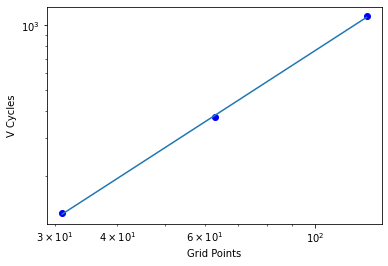

In [2]:
def T(v):
    ans = np.zeros(2*(len(v)-1) + 1)
    for i in range(len(ans)):
        if i % 2 == 0:
            ans[i] = v[i//2]
        else:
            ans[i] = (v[i//2] + v[i//2 + 1]) / 2
    return ans

def R(v):
    ans = np.zeros((len(v)-1)//2 + 1)
    ans[0] = v[0]
    ans[-1] = v[-1]
    for i in range(1, len(ans) - 1):
        j = 2 * (i-1) + 1
        ans[i] = (v[j] + 2*v[j+1] + v[j+2]) / 4
    return ans

g = 5
v_down = 2
v_up = 2
def multigrid(m):        
    def multi(u, b, i, data):
        n = int(np.log2(m + 1))
        grid_size = 2**(n - i) + 1
        Di, Li, Ui = data[i]
        Ai = Di - Li - Ui
        
        # coarsest grid, return exact solution
        if grid_size == g:
            return np.linalg.solve(Ai, b)

        DLinv = np.linalg.inv(Di - Li)
        X = DLinv@Ui
        v = DLinv@b
        for j in range(v_down):
            u = X@u + v
            
        r = R(b - Ai@u)
        u += T(multi(np.zeros(len(r)), r, i+1, data))
        for j in range(v_up):
            u = X@u + v
        return u
    
    # precompute D^i,L^i,U^i for all grids
    top_level = int(np.log2(m + 1))
    min_level = int(np.log2(g - 1))
    data = []
    for i in range(top_level, min_level-1, -1):
        grid_size = 2**i - 1
        data.append(build_A_matrix(grid_size))
    
    D,L,U = data[0]
    F = get_source(m)
    A = D - L - U
    u = np.zeros(m+2)
    k = 0
    while True:
        k += 1
        u = multi(u, F, 0, data)
        r = A@u - F
        if np.linalg.norm(r) < 1e-8:
            break
    return k
    
cycles = []
for m in ms:
    k = multigrid(m)
    print(f"m={m}\t k={k}")
    cycles.append(k)
    
fit_loglog(ms, cycles, "Grid Points", "V Cycles")

We now get cycles $\approx O(m^{1.49})$ which is much better than the previous method.